In [1]:
import random
import numpy as np
numbers = range(1, 1000000)
random_30000_users = random.sample(numbers, 30000)

In [3]:
len(np.unique(random_30000_users))

30000

In [ ]:
# import aiohttp
# import asyncio

# data = []

# async def main():

#     async with aiohttp.ClientSession() as session:
#         for number in random_1000_users:
#             print(number)
#             data_url = f"http://128.2.204.215:8080/user/{number}"
#             async with session.get(data_url) as resp:
#                 response = await resp.json()
#                 data.append(response)
# await main()

Streaming output truncated to the last 5000 lines.
202469
575343
974825
757246
776093
943940
714794
257119
149259
762366
974647
579016
898424
36619
694029
565300
342866
576707
551272
889755
561790
216924
695675
950565
214786
387583
569087
90586
346012
443776
270971
211438
527819
642425
122030
178693
409081
902012
766551
501975
6900
420179
535641
907198
944033
511027
718597
716835
272989
948662
879044
866980
359610
436347
234937
600810
817624
523774
618241
400825
826673
144006
105755
71608
889039
598484
50226
765828
825859
123440
993709
790536
802811
105671
790505
74791
976865
547854
652799
772606
54353
220130
101448
29198
286321
97307
257707
845757
812470
683668
535377
840381
501615
708688
885006
862300
103452
768037
557390
649769
345229
616632
890280
257954
271593
267850
215552
255070
549344
92616
550607
266432
762062
281897
810509
858757
525262
773829
32936
961521
354314
278108
235512
204045
199774
106152
356010
370204
898665
590895
593186
733190
17461
66955
370974
119052
108082
4402

In [ ]:
# kafka_ratings : 170k rec, 22k uniq users

In [ ]:
# 1k randomly -> fair sample
# dist of gender and age buckets
# model for these 1000, get acc
# model for male, get acc
# model for female, get acc

# accm-accf~0 in gender

# acc_age>50-acc_age<50~0 in age


# req 1: pick equal samples of age 
# req 2: pick equal samples of gender
# before modelling


In [4]:
import pandas as pd 
# df=pd.DataFrame(data)
# df.to_csv("user_info.csv")
# df.to_csv("/content/drive/MyDrive/user_info.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
df_users=pd.read_csv('user_info.csv')

In [6]:
df_users.describe(include='all')

,Unnamed: 0,user_id,age,occupation,gender
count,30000.000000,30000.000000,30000.000000,30000,30000
unique,NaN,NaN,NaN,21,2
top,NaN,NaN,NaN,college/grad student,M
freq,NaN,NaN,NaN,7346,24835
mean,14999.500000,496563.178167,30.119733,NaN,NaN
std,8660.398374,288244.566536,8.249186,NaN,NaN
min,0.000000,51.000000,8.000000,NaN,NaN
25%,7499.750000,246512.500000,26.000000,NaN,NaN
50%,14999.500000,496581.000000,29.000000,NaN,NaN
75%,22499.250000,747273.250000,32.000000,NaN,NaN


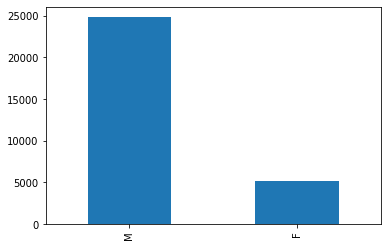

In [7]:
df_users['gender'].value_counts().plot(kind='bar')

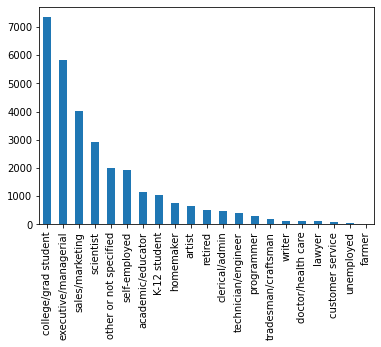

In [8]:
df_users['occupation'].value_counts().plot(kind='bar')

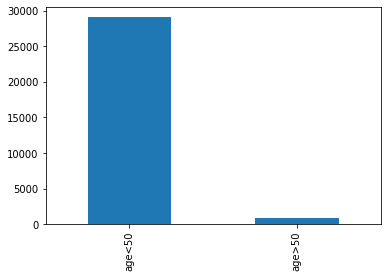

In [9]:
df_users['age_bucket']=df_users['age'].apply(lambda x:'age<50' if x<50 else 'age>50')
df_users['age_bucket'].value_counts().plot(kind='bar')

Adding the modelling codes


In [11]:
%pip install scikit-surprise
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 13.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626467 sha256=d430f948bf4736affaa69f4a60a1c91bf892fbcb2aeee6441b4d99a754972f26
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# DataPreProcessing.py

import pandas as pd

def DataPreProcessing(file_path="/content/drive/MyDrive/MLIP/kafka_ratings.txt",save_as="/content/drive/MyDrive/MLIP/preprocessed.csv"):
  df=pd.read_csv("/content/drive/MyDrive/MLIP/kafka_ratings.txt",header=None)
  
  df.columns=["Timestamp","UserID","Log"]

  df["MovieName=Rating"]=df["Log"].apply(lambda x: x.split("/")[2])
  df["MovieName"]=df["MovieName=Rating"].apply(lambda x: x.split("=")[0])
  df["rating"]=df["MovieName=Rating"].apply(lambda x: x.split("=")[1])
  
  Data=df[["UserID","MovieName","rating","Timestamp"]]
  
  
  # Data sort on timestamp

  # Few duplicates of user-> movie were dropped, the lateset was picked
  Data=Data.drop_duplicates(subset=['UserID', 'MovieName'],keep="last")
  print("Data.shape",Data.shape)
  
  #Exception handling for data save
  try : 
    Data.to_csv(save_as)
    print("Saved at: ",save_as)
    return True
  except:
    print("Unable to save at: ",save_as)
    return False

In [16]:
from collections import defaultdict
import json

def make_Dictionaries(processed_data_file="/content/drive/MyDrive/MLIP/preprocessed.csv",dictionary_storage_location="/content/drive/MyDrive/MLIP/"):
  Data=pd.read_csv(processed_data_file)

    
  # Function to return a default
  # values for keys that is not
  # present
  def def_value():
      return "Not Present"
        
  # Defining the dict
  iid_dict = defaultdict(def_value)
  uid_dict = defaultdict(def_value)
  sort_movies=Data['MovieName'].unique()
  sort_movies.sort()
  for i in range(len(sort_movies)):
    iid_dict[sort_movies[i]]=i

  sort_users=Data['UserID'].unique()
  sort_users.sort()
  for i in range(len(sort_users)):
    uid_dict[int(sort_users[i])]=i

  with open(dictionary_storage_location+"iid_dict.json", "w") as outfile:
    json.dump(iid_dict, outfile)
  with open(dictionary_storage_location+"uid_dict.json", "w") as outfile:
    json.dump(uid_dict, outfile)

  return True


In [17]:
# importing the module
import json
 
def DataRemapping(processed_data_file="/content/drive/MyDrive/MLIP/preprocessed.csv",dictionary_storage_location="/content/drive/MyDrive/MLIP/"):
  # Opening JSON file
  with open(dictionary_storage_location+'iid_dict.json') as json_file:
      iid_dict = json.load(json_file)
  with open(dictionary_storage_location+'uid_dict.json') as json_file:
      uid_dict = json.load(json_file)
  def def_value():
      return "Not Present"
        
  # Defining the dict
  iid_dict = defaultdict(int,iid_dict)
  uid_dict = defaultdict(int,uid_dict)
  
  Data=pd.read_csv(processed_data_file)
  Data['item']=Data['MovieName'].apply(lambda x: iid_dict[x])
  Data['user']=Data['UserID'].apply(lambda x: uid_dict[str(x)])
  # print(Data.head())
  Data_selected=Data[['user','item','rating']]
  # print(Data_selected.head())
  Data_selected.to_csv(dictionary_storage_location+"RemappedData.csv")
  
  User_watched_movies=Data_selected.groupby('user')['item'].apply(list)
  User_watched_movies=dict(User_watched_movies)
  with open(dictionary_storage_location+"Users_Watched_Movies.json", "w") as outfile:
    json.dump(User_watched_movies, outfile)
  
  return True

In [ ]:
# the predict function for any algorithm
def predict(algo,uid,iid,r=4):
  ret=algo.predict(int(uid),int(iid),r)
  # print(ret)
  return ret

In [ ]:
# storing and retreiving model objects

import pickle 

def store_model_into_pickle(algo,algo_name,dest_location="/content/drive/MyDrive/Collab Codes/MLIP/"):
  file1 = open(dest_location+algo_name+".pickle", "wb")
  pickle.dump(algo, file1)
  file1.close()
  print(algo_name+" Stored at/as :"+dest_location+algo_name+".pickle")
  return True
  
def get_model_from_pickle(algo_name,file_location="/content/drive/MyDrive/Collab Codes/MLIP/"):
  file_to_read = open(file_location+algo_name+".pickle", "rb")
  loaded_object = pickle.load(file_to_read)
  file_to_read.close()
  print("returned model object")
  return loaded_object



In [22]:
from operator import itemgetter

def recommend_top_20_modviesForUser(algo_name,og_user,dictionary_storage_location="/content/drive/MyDrive/MLIP/"):
  og_user=str(og_user)
  algo=get_model_from_pickle(algo_name=algo_name)
  with open(dictionary_storage_location+'iid_dict.json') as json_file:
      iid_dict = json.load(json_file)
  with open(dictionary_storage_location+'uid_dict.json') as json_file:
      uid_dict = json.load(json_file)
  with open(dictionary_storage_location+'Users_Watched_Movies.json') as json_file:
      Users_Watched_Movies = json.load(json_file)
  def def_value():
      return "Not Present"
        
  # Defining the dict
  iid_dict = defaultdict(int,iid_dict)
  uid_dict = defaultdict(int,uid_dict)

  #Defining inverted dictionaries
  inv_uid = {v: k for k, v in uid_dict.items()}
  inv_iid = {v: k for k, v in iid_dict.items()}


  model_uid=str(uid_dict[og_user])
  print("MODEL UID:",model_uid,"OG ID",og_user)
  all_movies_user_saw=Users_Watched_Movies[model_uid]

  setA = set(list(iid_dict.values()))
  setB = set(all_movies_user_saw)

  # Removing movies which user has already seen
  onlyInA = setA.difference(setB)
  predictions=[]
  for movie in onlyInA:
    predictions.append(predict(algo,model_uid,movie)[3])

  preds_for_a_user=dict(zip(onlyInA,predictions))
  top20movieIDs = dict(sorted(preds_for_a_user.items(), key = itemgetter(1), reverse = True)[:20])
  # print(top20movieIDs)
  top20movieNames=[inv_iid[i] for i in list(top20movieIDs.keys())]
  out_json={"message": "OK", "recommendations": top20movieNames }
  return out_json

In [23]:
# Code to get a model's performace, wrt : Avg. Training time and RMSE on a K-Folded Cross Validation Process
# Assumption that a model has been trained earlier, however, this below process only uses the architecture and not the trained model. It will re-fit the data again.
# Hence, Data Location is essential.
# The purpose of this code is only model evaualtion for the sake of seperation of concerns.

from surprise import Reader
from surprise import NMF
from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise.accuracy import rmse
from surprise.model_selection import KFold
import numpy as np
import pandas as pd
import pickle 
import requests

#Please update your desitination location if its different

#Codes to store the model into pickle 
def store_model_into_pickle(algo,algo_name,dest_location="/content/drive/MyDrive/Collab Codes/MLIP/"):
  file1 = open(dest_location+algo_name+".pickle", "wb")
  pickle.dump(algo, file1)
  file1.close()
  print(algo_name+" Stored at/as :"+dest_location+algo_name+".pickle")
  return True

#Codes to get the model from pickle 
def get_model_from_pickle(algo_name,file_location="/content/drive/MyDrive/Collab Codes/MLIP/"):
  file_to_read = open(file_location+algo_name+".pickle", "rb")
  loaded_object = pickle.load(file_to_read)
  file_to_read.close()
  print("returned model object")
  return loaded_object



def get_avg_throughputtime(data_location="/content/drive/MyDrive/MLIP/preprocessed.csv"):
  df=pd.read_csv(data_location)
  request_list=['http://128.2.205.106:8082/recommend/'+str(i) for i in np.unique(df.UserID.sample(500))]

  times=[]
  # Making a get request
  for i in request_list:
    response = requests.get(i)
    times.append(response.elapsed.total_seconds())

  print("AVG Throughput",np.mean(times))
  return np.mean(times)

# An existing model architechture chan be passed to the below code, and the code will re-fit the model on the k-folded data and give the most realistic k-fold cross validation RMSE
def evaluate_model(model_name="svdpp_model",processed__test_data_file="/content/drive/MyDrive/Collab Codes/MLIP/RemappedData.csv"):

  algo=get_model_from_pickle(model_name)
  Data_selected=pd.read_csv(processed__test_data_file)
  reader = Reader(rating_scale=(1, 5))

  # Loads Pandas dataframe
  data = Dataset.load_from_df(Data_selected[["user", "item", "rating"]], reader)

  #KFold helps us to spit the dataset into n folds, this will help us seperate training and testing splits while calculating testing erros

  kf = KFold(n_splits=4)
  errors=[]
  training_time=[]
  for trainset, testset in kf.split(data):
    start_time = time.time()
    #Fitting
    algo.fit(trainset)      
    end_time=time.time()               
    time_for_fitting=(time.time() - start_time)

    # we are checking for test rmse only, and computing avg of all CV in the k splits
    predictions = algo.test(testset)
    #appending results to a list for future references
    errors.append(rmse(predictions))
    training_time.append(time_for_fitting)
    
  # This code only returns the avg RMSE error and avg training time for a k folded dataset
  return np.mean(errors),np.mean(training_time)

In [24]:
# FINAL SEQUENTIAL EXECUTION ONE TIME
start_time = time.time()
DataPreProcessing()
end_time=time.time()
time_for_dataProcessing=(time.time() - start_time)

df=pd.read_csv("/content/drive/MyDrive/MLIP/preprocessed.csv")
sampled_df=df.sample(170000)
sampled_df.to_csv("/content/drive/MyDrive/MLIP/sampled_170kpreprocessed.csv")


Data.shape (435452, 4)
Saved at:  /content/drive/MyDrive/MLIP/preprocessed.csv


In [39]:
from surprise import Reader
from surprise import Dataset
import pandas as pd
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise.model_selection import KFold
from sklearn.model_selection import train_test_split

def train_SVD_wGridSearch(processed_data_file="/content/drive/MyDrive/MLIP/RemappedData.csv"):
  
  Data_selected=pd.read_csv(processed_data_file)

  reader = Reader(rating_scale=(1, 5))

  # Loads Pandas dataframe
  df2=Data_selected[["user", "item", "rating"]]

  train,test = train_test_split(df2, test_size=0.33, shuffle=False)

  data = Dataset.load_from_df(train, reader)
  test = Dataset.load_from_df(test, reader)



  """
  lr_all is the learning rate for all parameters (how much the parameters are adjusted in each iteration)
  reg_all is the regularization term for all parameters, which is a penalty term added to prevent overfitting.
  """

  # param_grid = {
  #     "n_epochs": [5, 10],
  #     "lr_all": [0.002, 0.005],
  #     "reg_all": [0.4, 0.6]
  # }

  # Get the best params using GridSearchCV
  # gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
  # gs.fit(data)
  # Post GS we have the below params
  # best_params=best_params = gs.best_params["rmse"]
  best_params={'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
  # print("BEST PARAM:",best_params)
  # Extract and train model with best params
  svd_algo = SVD(n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'],
                reg_all=best_params['reg_all'])
  # Train
  trainingSet = data.build_full_trainset()
  testingSet = test.build_full_trainset()

  svd_algo.fit(trainingSet)

  kf = KFold(n_splits=2)
  errors=[]
  for trainset,testset in kf.split(testingSet):
    predictions = svd_algo.test(testset)
    errors.append(rmse(predictions))

  return svd_algo,np.mean(errors)

In [40]:
# start_time = time.time()
# make_Dictionaries(processed_data_file="/content/drive/MyDrive/MLIP/sampled_170kpreprocessed.csv")
# DataRemapping(processed_data_file="/content/drive/MyDrive/MLIP/sampled_170kpreprocessed.csv")
# end_time=time.time()
# time_for_dataReMapping=(time.time() - start_time)


In [60]:
processed_data_file="/content/drive/MyDrive/MLIP/RemappedData.csv"
  
Data_selected=pd.read_csv(processed_data_file)

reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
df2=Data_selected[["user", "item", "rating"]]

train,test = train_test_split(df2, test_size=0.33, shuffle=False)

data = Dataset.load_from_df(df2, reader)
train = Dataset.load_from_df(train, reader)
test = Dataset.load_from_df(test, reader)

best_params={'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}

svd_algo = SVD(n_epochs=best_params['n_epochs'],
              lr_all=best_params['lr_all'],
              reg_all=best_params['reg_all'])
# Train
trainingSet = data.build_full_trainset()
testingSet = test.build_full_trainset()
fullSet = data.build_full_trainset()
svd_algo.fit(trainingSet)
predictions = svd_algo.test(testingSet.build_testset())
print("ERROR",rmse(predictions))

predictions_full_data = svd_algo.test(fullSet.build_testset())
print("ERROR",rmse(predictions_full_data))


RMSE: 0.8541
ERROR 0.8541172876943747
RMSE: 0.8566
ERROR 0.8565519992106183


In [64]:
# importing the module
import json
  
# reading the data from the file
with open('/content/drive/MyDrive/MLIP/uid_dict.json') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
js = json.loads(data)
  
print("Data type after reconstruction : ", type(js))

inv_uid = {v: k for k, v in js.items()}
print(inv_uid)

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
{0: '5', 1: '9', 2: '10', 3: '13', 4: '14', 5: '24', 6: '25', 7: '32', 8: '37', 9: '38', 10: '41', 11: '42', 12: '51', 13: '52', 14: '55', 15: '56', 16: '62', 17: '69', 18: '88', 19: '104', 20: '110', 21: '112', 22: '113', 23: '115', 24: '120', 25: '123', 26: '125', 27: '133', 28: '134', 29: '138', 30: '142', 31: '151', 32: '153', 33: '159', 34: '160', 35: '161', 36: '170', 37: '174', 38: '181', 39: '184', 40: '185', 41: '187', 42: '209', 43: '217', 44: '230', 45: '234', 46: '247', 47: '249', 48: '257', 49: '267', 50: '269', 51: '275', 52: '276', 53: '281', 54: '282', 55: '283', 56: '284', 57: '288', 58: '293', 59: '301', 60: '302', 61: '308', 62: '312', 63: '320', 64: '322', 65: '326', 66: '333', 67: '340', 68: '344', 69: '347', 70: '350', 71: '352', 72: '359', 73: '372', 74: '379', 75: '384', 76: '385', 77: '389', 78: '404', 79: '406', 80: '408', 81: '413', 82: '417', 83: '418', 84: '430

In [91]:
df_users
df_users['age_bucket']=df_users['age'].apply(lambda x:'age<50' if x<50 else 'age>50')

In [92]:
df_users['user_id']=df_users['user_id'].astype('int')

In [104]:
all_predictions=pd.DataFrame(predictions_full_data)
all_predictions['OG_UID']=all_predictions['uid'].apply(lambda x: int(inv_uid[x]))
all_predictions.head()

,uid,iid,r_ui,est,details,OG_UID
0,4485,4312,4.0,3.575900,{'was_impossible': False},18549
1,4485,2695,5.0,4.001895,{'was_impossible': False},18549
2,4485,7990,5.0,4.069178,{'was_impossible': False},18549
3,36447,14210,5.0,4.227381,{'was_impossible': False},151979
4,36447,9374,3.0,3.683634,{'was_impossible': False},151979


In [105]:
merged_preds=pd.merge(left=all_predictions,right=df_users,left_on='OG_UID',right_on='user_id',how='inner')
merged_preds_final=merged_preds[['OG_UID','r_ui','est','age',	'occupation',	'gender','age_bucket']]

In [106]:
merged_preds_final['RMSE']=(merged_preds_final['r_ui']-merged_preds_final['est'])**2
merged_preds_final.head()

<ipython-input-106-c453a0ea1d3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_preds_final['RMSE']=(merged_preds_final['r_ui']-merged_preds_final['est'])**2


,OG_UID,r_ui,est,age,occupation,gender,age_bucket,RMSE
0,199145,4.0,3.403592,29,sales/marketing,M,age<50,0.355703
1,199145,5.0,3.950506,29,sales/marketing,M,age<50,1.101437
2,42974,4.0,3.737465,34,sales/marketing,F,age<50,0.068925
3,228983,1.0,2.729603,30,executive/managerial,M,age<50,2.991527
4,228983,3.0,3.594784,30,executive/managerial,M,age<50,0.353768


In [112]:
merged_preds_final.shape

(5177, 8)

In [113]:
len(np.unique(merged_preds_final.OG_UID))

1698

In [107]:
merged_preds_final.groupby('gender').agg({'RMSE':lambda x : sum(x)**0.5, 
                         'est':'mean', 
                         'r_ui':'mean',
                         'gender':'count',
                         })

,RMSE,est,r_ui,gender
gender,,,,
F,26.062642,3.697309,3.712088,910
M,55.839189,3.653697,3.624092,4267


In [110]:
merged_preds_final.groupby('occupation').agg({'RMSE':lambda x : sum(x)**0.5, 
                         'est':'mean', 
                         'r_ui':'mean',
                         'occupation':'count',
                         })

,RMSE,est,r_ui,occupation
occupation,,,,
K-12 student,12.981064,3.675763,3.664894,188
academic/educator,11.309833,3.766942,3.839572,187
artist,8.240955,3.627317,3.719298,114
clerical/admin,6.455075,3.600959,3.563636,55
college/grad student,30.530136,3.664864,3.673122,1291
customer service,4.413301,3.741474,4.280000,25
doctor/health care,3.806176,3.570841,3.208333,24
executive/managerial,27.199964,3.669803,3.619704,1015
farmer,4.667673,3.789837,3.421053,19


In [111]:
merged_preds_final.groupby('age_bucket').agg({'RMSE':lambda x : sum(x)**0.5, 
                         'est':'mean', 
                         'r_ui':'mean',
                         'age_bucket':'count',
                         })

,RMSE,est,r_ui,age_bucket
age_bucket,,,,
age<50,60.575101,3.660396,3.639801,5025
age>50,11.310769,3.693310,3.631579,152
